<a href="https://colab.research.google.com/github/savina31/darts/blob/main/CNNKlasifikasiBan_(SGD)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
OptimizerOptions = 'sgd'
epochOptions = 50

# Skenario 1

In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir train
!mkdir test

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists


In [ ]:
import os

dir_latih = '/content/gdrive/MyDrive/ban/train'
dir_test = '/content/gdrive/MyDrive/ban/test'
dir_latih_target = '/content/train'
dir_test_target = '/content/test'

In [ ]:
import cv2
import os
import numpy as np
from shutil import copyfile

# Define the edge detection function
def apply_canny_edge_detection(image_path, target_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform edge detection using Canny algorithm
    edges = cv2.Canny(gray, 100, 200)

    # Save the edge detected image to target path
    cv2.imwrite(target_path, edges)

# Define the dataset directory paths
dir_latih = '/content/gdrive/MyDrive/ban/train'
dir_test = '/content/gdrive/MyDrive/ban/test'
dir_latih_target = '/content/train'
dir_test_target = '/content/test'

# Create the target directories if they don't exist
if not os.path.exists(dir_latih_target):
    os.makedirs(dir_latih_target)
if not os.path.exists(dir_test_target):
    os.makedirs(dir_test_target)

# Apply edge detection to the training dataset
for label in os.listdir(dir_latih):
    dir_label = os.path.join(dir_latih, label)
    dir_label_target = os.path.join(dir_latih_target, label)
    if not os.path.exists(dir_label_target):
        os.makedirs(dir_label_target)
    for file_name in os.listdir(dir_label):
        file_path = os.path.join(dir_label, file_name)
        file_path_target = os.path.join(dir_label_target, file_name)
        apply_canny_edge_detection(file_path, file_path_target)

# Apply edge detection to the testing dataset
for label in os.listdir(dir_test):
    dir_label = os.path.join(dir_test, label)
    dir_label_target = os.path.join(dir_test_target, label)
    if not os.path.exists(dir_label_target):
        os.makedirs(dir_label_target)
    for file_name in os.listdir(dir_label):
        file_path = os.path.join(dir_label, file_name)
        file_path_target = os.path.join(dir_label_target, file_name)
        apply_canny_edge_detection(file_path, file_path_target)


In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = learning_rate
    if epoch > 50:
        lr *= 0.1
    if epoch > 75:
        lr *= 0.1
    return lr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Define hyperparameters
epochs = epochOptions + 0 # not-constant
steps_per_epoch = 5
learning_rate = 0.01
batch_size = 10 # not-constant
validation_steps = 5
train_dir = dir_latih
test_dir = dir_test
optimizer = OptimizerOptions # not-constant

In [ ]:
# Define the model architecture
model = Sequential([
        layers.Reshape((250, 250, 3), input_shape=(250, 250, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

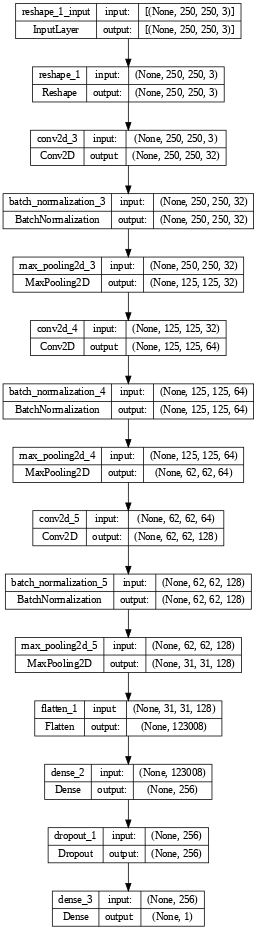

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [ ]:
# Define image data generator with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load image dataset
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

validation_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:

lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define callbacks
filepath_best_model = "best_model.h5"
checkpoint_best_model = ModelCheckpoint(filepath_best_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
filepath_acc_model = "model_acc_{accuracy:.2f}.h5"
checkpoint_acc_model = ModelCheckpoint(filepath_acc_model, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
  
# Train the model
history = model.fit(train_data, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=validation_data, validation_steps=validation_steps,
                        batch_size=batch_size,callbacks=[lr_scheduler, checkpoint_best_model, checkpoint_acc_model])

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 28.1208 - accuracy: 0.4800
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to best_model.h5

Epoch 1: saving model to model_acc_0.48.h5
5/5 [==============================] - 7s 1s/step - loss: 28.1208 - accuracy: 0.4800 - val_loss: 173.9218 - val_accuracy: 0.4800 - lr: 0.0100
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 53.7864 - accuracy: 0.4000
Epoch 2: val_accuracy improved from 0.48000 to 0.62000, saving model to best_model.h5

Epoch 2: saving model to model_acc_0.40.h5
5/5 [==============================] - 5s 1s/step - loss: 53.7864 - accuracy: 0.4000 - val_loss: 112.0907 - val_accuracy: 0.6200 - lr: 0.0100
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 26.9675 - accuracy: 0.5600
Epoch 3: val_accuracy did not improve from 0.62000

Epoch 3: saving model to model_acc_0.56.h5
5/5 [==============================] - 4s 932ms/step - loss: 26.9675 - accuracy: 0.56

In [ ]:
# Predict the labels of test data
y_pred = model.predict(validation_data)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels
y_true = validation_data.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

12/12 [==============================] - 2s 141ms/step - loss: 0.9098 - accuracy: 0.4333
Test loss: 0.9097755551338196
Test accuracy: 0.4333333373069763


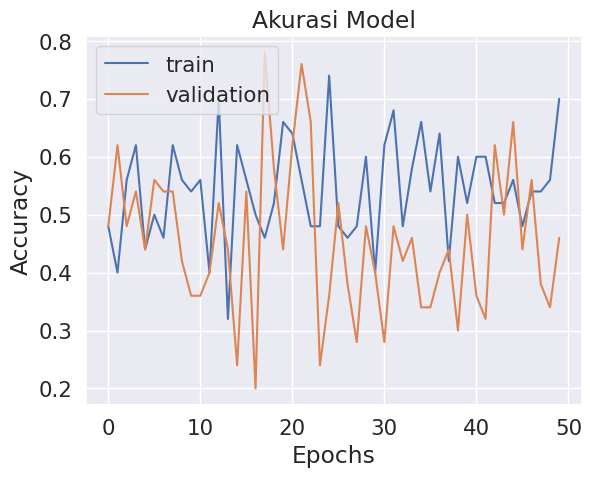

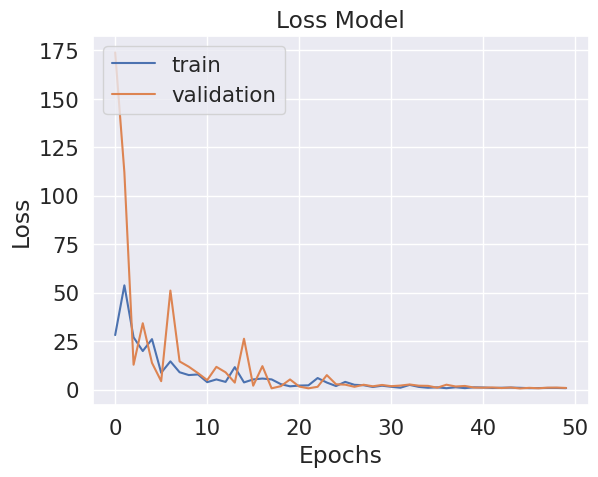

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

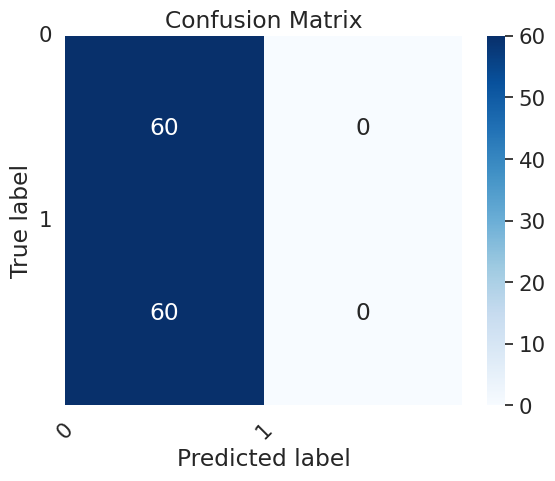

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define the labels
labels = ['0','1']
categories = ['Zero', 'One']

# create the confusion matrix plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)

# set the axis labels and the title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# add the labels for each cell
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels, rotation=0)

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# calculate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# print the classification report
print(report)


              precision    recall  f1-score   support

        Zero       0.50      1.00      0.67        60
         One       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Skenario 2

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = learning_rate
    if epoch > 50:
        lr *= 0.1
    if epoch > 75:
        lr *= 0.1
    return lr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Define hyperparameters
epochs = epochOptions + 20 # not-constant
steps_per_epoch = 5
learning_rate = 0.01
batch_size = 10 # not-constant
validation_steps = 5
train_dir = dir_latih
test_dir = dir_test
optimizer = OptimizerOptions # not-constant

In [ ]:
# Define the model architecture
model = Sequential([
        layers.Reshape((250, 250, 3), input_shape=(250, 250, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

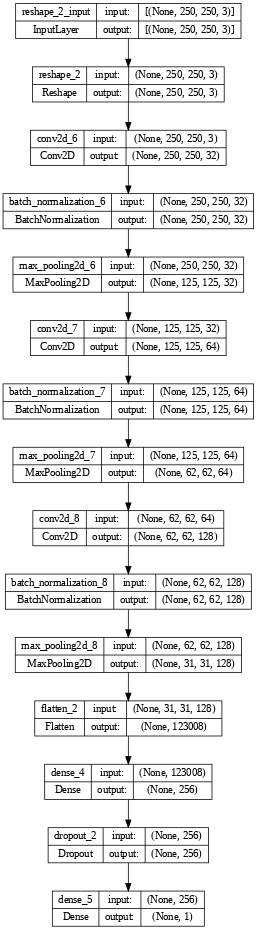

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [ ]:
# Define image data generator with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load image dataset
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

validation_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:

lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define callbacks
filepath_best_model = "best_model.h5"
checkpoint_best_model = ModelCheckpoint(filepath_best_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
filepath_acc_model = "model_acc_{accuracy:.2f}.h5"
checkpoint_acc_model = ModelCheckpoint(filepath_acc_model, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
  
# Train the model
history = model.fit(train_data, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=validation_data, validation_steps=validation_steps,
                        batch_size=batch_size,callbacks=[lr_scheduler, checkpoint_best_model, checkpoint_acc_model])

Epoch 1/70
5/5 [==============================] - ETA: 0s - loss: 5.8366 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.58000, saving model to best_model.h5

Epoch 1: saving model to model_acc_0.50.h5
5/5 [==============================] - 7s 1s/step - loss: 5.8366 - accuracy: 0.5000 - val_loss: 10.0555 - val_accuracy: 0.5800 - lr: 0.0100
Epoch 2/70
5/5 [==============================] - ETA: 0s - loss: 25.2465 - accuracy: 0.4200
Epoch 2: val_accuracy did not improve from 0.58000

Epoch 2: saving model to model_acc_0.42.h5
5/5 [==============================] - 5s 1s/step - loss: 25.2465 - accuracy: 0.4200 - val_loss: 4.2974 - val_accuracy: 0.4400 - lr: 0.0100
Epoch 3/70
5/5 [==============================] - ETA: 0s - loss: 20.9023 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.58000

Epoch 3: saving model to model_acc_0.50.h5
5/5 [==============================] - 5s 1s/step - loss: 20.9023 - accuracy: 0.5000 - val_loss: 1.0078 - val_accuracy: 0.560

In [ ]:
# Predict the labels of test data
y_pred = model.predict(validation_data)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels
y_true = validation_data.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

12/12 [==============================] - 2s 139ms/step - loss: 0.6498 - accuracy: 0.6917
Test loss: 0.6497966647148132
Test accuracy: 0.6916666626930237


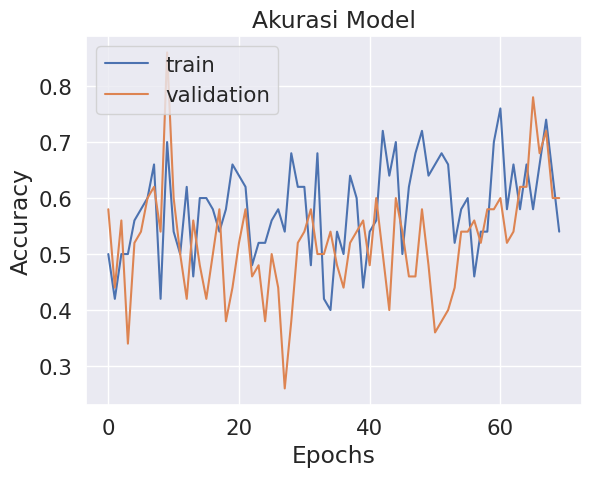

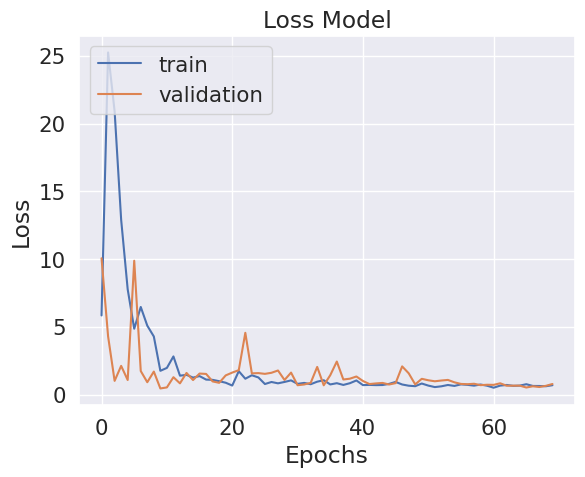

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

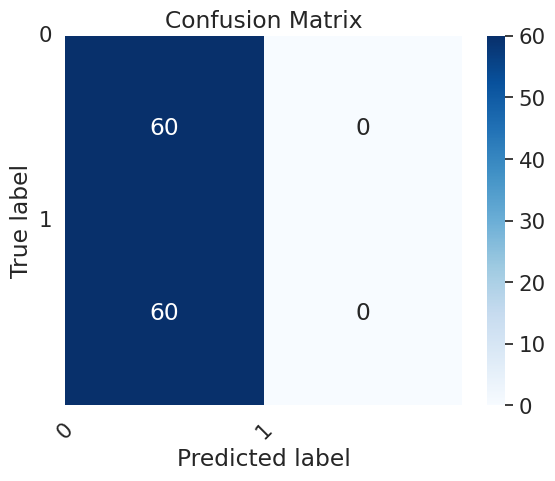

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define the labels
labels = ['0','1']
categories = ['Zero', 'One']

# create the confusion matrix plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)

# set the axis labels and the title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# add the labels for each cell
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels, rotation=0)

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# calculate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# print the classification report
print(report)


              precision    recall  f1-score   support

        Zero       0.50      1.00      0.67        60
         One       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Skenario 3

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = learning_rate
    if epoch > 50:
        lr *= 0.1
    if epoch > 75:
        lr *= 0.1
    return lr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Define hyperparameters
epochs = epochOptions + 40 # not-constant
steps_per_epoch = 5
learning_rate = 0.01
batch_size = 10 # not-constant
validation_steps = 5
train_dir = dir_latih
test_dir = dir_test
optimizer = OptimizerOptions # not-constant

In [ ]:
# Define the model architecture
model = Sequential([
        layers.Reshape((250, 250, 3), input_shape=(250, 250, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

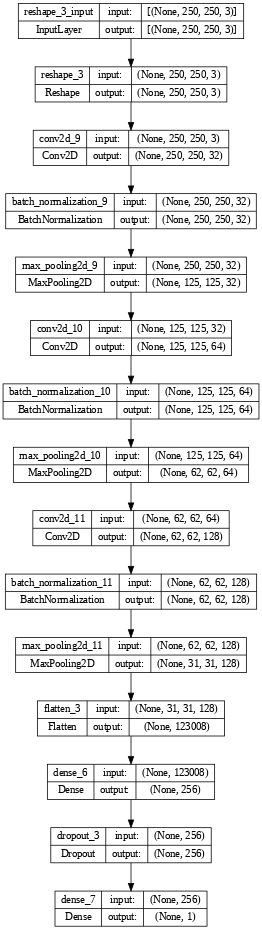

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [ ]:
# Define image data generator with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load image dataset
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

validation_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:

lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define callbacks
filepath_best_model = "best_model.h5"
checkpoint_best_model = ModelCheckpoint(filepath_best_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
filepath_acc_model = "model_acc_{accuracy:.2f}.h5"
checkpoint_acc_model = ModelCheckpoint(filepath_acc_model, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
  
# Train the model
history = model.fit(train_data, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=validation_data, validation_steps=validation_steps,
                        batch_size=batch_size,callbacks=[lr_scheduler, checkpoint_best_model, checkpoint_acc_model])

Epoch 1/90
5/5 [==============================] - ETA: 0s - loss: 30.6897 - accuracy: 0.4000
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to best_model.h5

Epoch 1: saving model to model_acc_0.40.h5
5/5 [==============================] - 7s 1s/step - loss: 30.6897 - accuracy: 0.4000 - val_loss: 7.6729 - val_accuracy: 0.4800 - lr: 0.0100
Epoch 2/90
5/5 [==============================] - ETA: 0s - loss: 16.7355 - accuracy: 0.5400
Epoch 2: val_accuracy improved from 0.48000 to 0.52000, saving model to best_model.h5

Epoch 2: saving model to model_acc_0.54.h5
5/5 [==============================] - 6s 1s/step - loss: 16.7355 - accuracy: 0.5400 - val_loss: 3.1504 - val_accuracy: 0.5200 - lr: 0.0100
Epoch 3/90
5/5 [==============================] - ETA: 0s - loss: 30.3080 - accuracy: 0.5400
Epoch 3: val_accuracy did not improve from 0.52000

Epoch 3: saving model to model_acc_0.54.h5
5/5 [==============================] - 7s 1s/step - loss: 30.3080 - accuracy: 0.5400 - va

In [ ]:
# Predict the labels of test data
y_pred = model.predict(validation_data)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels
y_true = validation_data.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

12/12 [==============================] - 2s 145ms/step - loss: 0.6536 - accuracy: 0.7000
Test loss: 0.6535965800285339
Test accuracy: 0.699999988079071


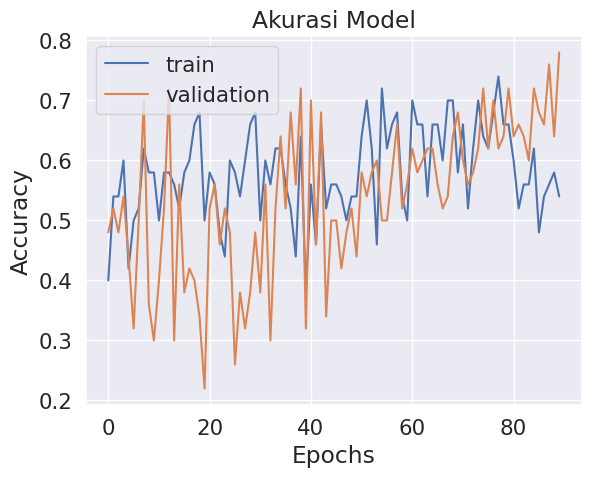

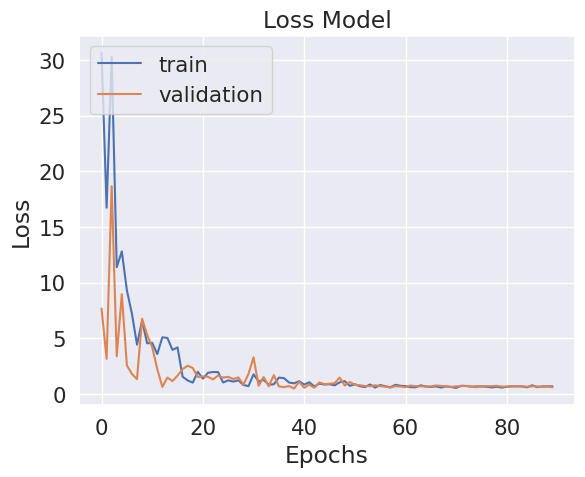

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

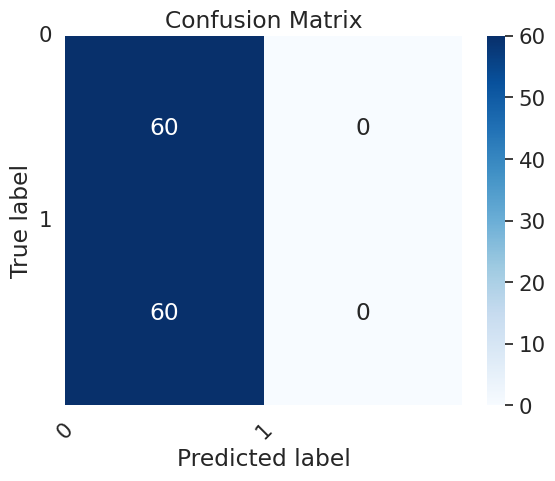

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define the labels
labels = ['0','1']
categories = ['Zero', 'One']

# create the confusion matrix plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)

# set the axis labels and the title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# add the labels for each cell
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels, rotation=0)

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# calculate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# print the classification report
print(report)


              precision    recall  f1-score   support

        Zero       0.50      1.00      0.67        60
         One       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Skenario 4

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = learning_rate
    if epoch > 50:
        lr *= 0.1
    if epoch > 75:
        lr *= 0.1
    return lr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Define hyperparameters
epochs = epochOptions + 50 # not-constant
steps_per_epoch = 5
learning_rate = 0.01
batch_size = 10 # not-constant
validation_steps = 5
train_dir = dir_latih
test_dir = dir_test
optimizer = OptimizerOptions # not-constant

In [ ]:
# Define the model architecture
model = Sequential([
        layers.Reshape((250, 250, 3), input_shape=(250, 250, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

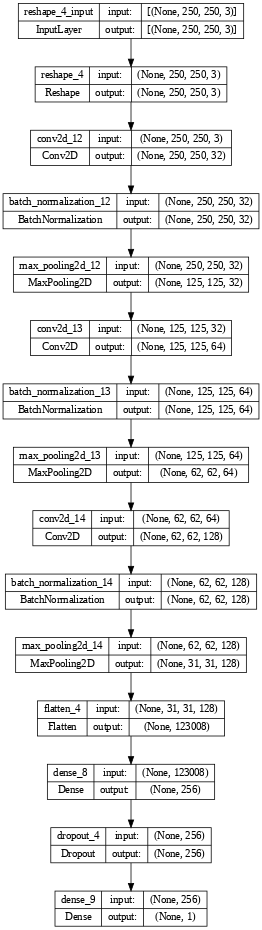

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [ ]:
# Define image data generator with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load image dataset
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

validation_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:

lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define callbacks
filepath_best_model = "best_model.h5"
checkpoint_best_model = ModelCheckpoint(filepath_best_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
filepath_acc_model = "model_acc_{accuracy:.2f}.h5"
checkpoint_acc_model = ModelCheckpoint(filepath_acc_model, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
  
# Train the model
history = model.fit(train_data, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=validation_data, validation_steps=validation_steps,
                        batch_size=batch_size,callbacks=[lr_scheduler, checkpoint_best_model, checkpoint_acc_model])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 14.6405 - accuracy: 0.5400
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5

Epoch 1: saving model to model_acc_0.54.h5
5/5 [==============================] - 7s 1s/step - loss: 14.6405 - accuracy: 0.5400 - val_loss: 2.1814 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 21.0413 - accuracy: 0.4400
Epoch 2: val_accuracy did not improve from 0.50000

Epoch 2: saving model to model_acc_0.44.h5
5/5 [==============================] - 6s 1s/step - loss: 21.0413 - accuracy: 0.4400 - val_loss: 4.5008 - val_accuracy: 0.4600 - lr: 0.0100
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 10.4088 - accuracy: 0.5200
Epoch 3: val_accuracy did not improve from 0.50000

Epoch 3: saving model to model_acc_0.52.h5
5/5 [==============================] - 4s 1s/step - loss: 10.4088 - accuracy: 0.5200 - val_loss: 0.6549 - val_accuracy: 0

In [ ]:
# Predict the labels of test data
y_pred = model.predict(validation_data)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels
y_true = validation_data.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

12/12 [==============================] - 2s 135ms/step - loss: 0.5911 - accuracy: 0.6750
Test loss: 0.5911304354667664
Test accuracy: 0.675000011920929


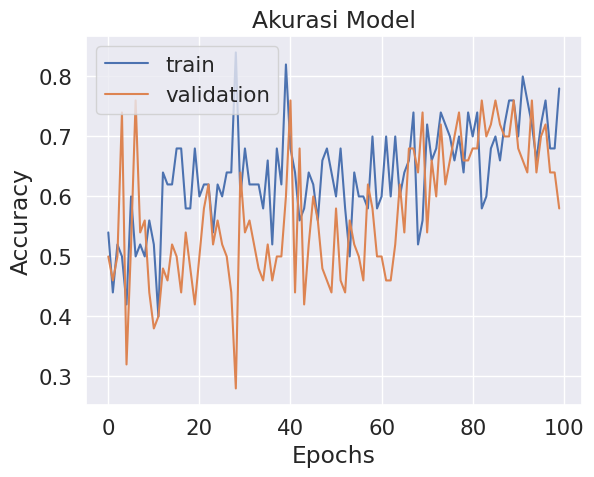

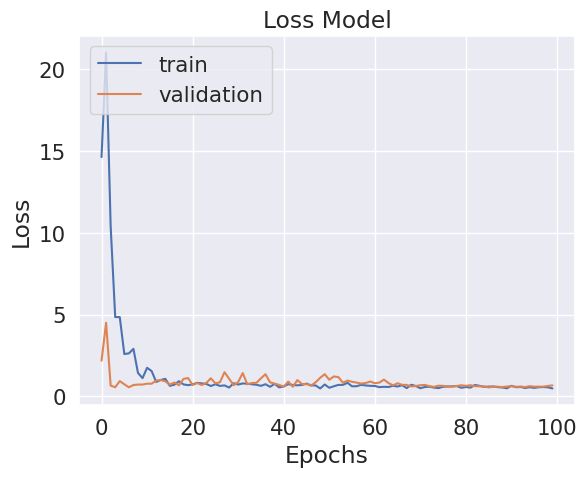

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

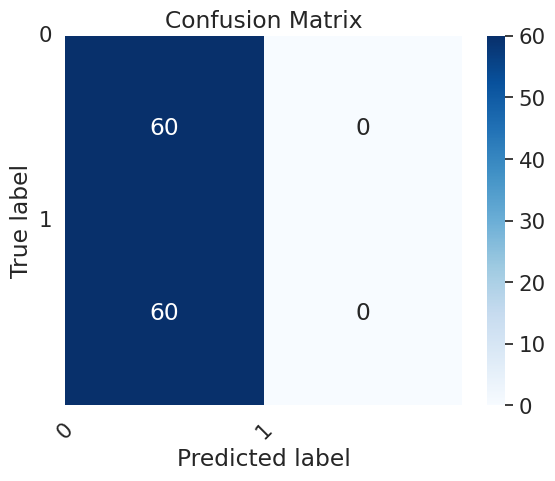

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define the labels
labels = ['0','1']
categories = ['Zero', 'One']

# create the confusion matrix plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)

# set the axis labels and the title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# add the labels for each cell
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels, rotation=0)

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# calculate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# print the classification report
print(report)


              precision    recall  f1-score   support

        Zero       0.50      1.00      0.67        60
         One       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Skenario 5

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = learning_rate
    if epoch > 50:
        lr *= 0.1
    if epoch > 75:
        lr *= 0.1
    return lr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Define hyperparameters
epochs = epochOptions + 100 # not-constant
steps_per_epoch = 5
learning_rate = 0.01
batch_size = 10 # not-constant
validation_steps = 5
train_dir = dir_latih
test_dir = dir_test
optimizer = OptimizerOptions # not-constant

In [ ]:
# Define the model architecture
model = Sequential([
        layers.Reshape((250, 250, 3), input_shape=(250, 250, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

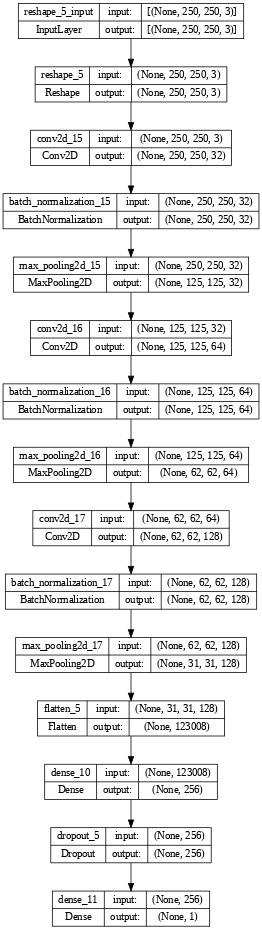

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [ ]:
# Define image data generator with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load image dataset
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

validation_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:

lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define callbacks
filepath_best_model = "best_model.h5"
checkpoint_best_model = ModelCheckpoint(filepath_best_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
filepath_acc_model = "model_acc_{accuracy:.2f}.h5"
checkpoint_acc_model = ModelCheckpoint(filepath_acc_model, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
  
# Train the model
history = model.fit(train_data, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=validation_data, validation_steps=validation_steps,
                        batch_size=batch_size,callbacks=[lr_scheduler, checkpoint_best_model, checkpoint_acc_model])

Epoch 1/150
5/5 [==============================] - ETA: 0s - loss: 17.4533 - accuracy: 0.6000
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to best_model.h5

Epoch 1: saving model to model_acc_0.60.h5
5/5 [==============================] - 8s 2s/step - loss: 17.4533 - accuracy: 0.6000 - val_loss: 28.8806 - val_accuracy: 0.5200 - lr: 0.0100
Epoch 2/150
5/5 [==============================] - ETA: 0s - loss: 20.9159 - accuracy: 0.5200
Epoch 2: val_accuracy did not improve from 0.52000

Epoch 2: saving model to model_acc_0.52.h5
5/5 [==============================] - 5s 1s/step - loss: 20.9159 - accuracy: 0.5200 - val_loss: 22.2651 - val_accuracy: 0.4200 - lr: 0.0100
Epoch 3/150
5/5 [==============================] - ETA: 0s - loss: 16.5368 - accuracy: 0.5400
Epoch 3: val_accuracy did not improve from 0.52000

Epoch 3: saving model to model_acc_0.54.h5
5/5 [==============================] - 6s 1s/step - loss: 16.5368 - accuracy: 0.5400 - val_loss: 26.1488 - val_accuracy

In [ ]:
# Predict the labels of test data
y_pred = model.predict(validation_data)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels
y_true = validation_data.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

12/12 [==============================] - 2s 131ms/step - loss: 0.5900 - accuracy: 0.6750
Test loss: 0.5900110006332397
Test accuracy: 0.675000011920929


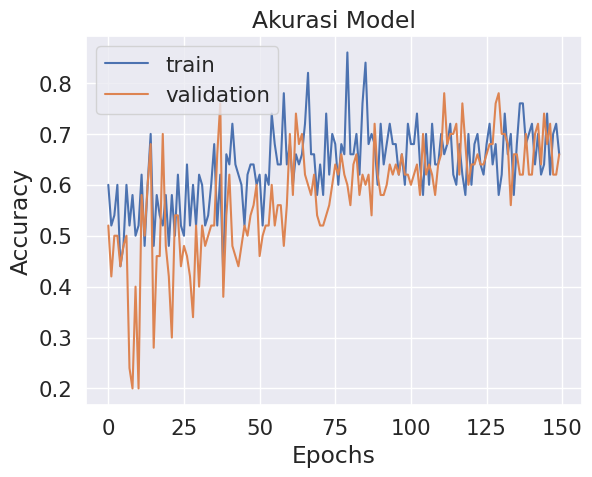

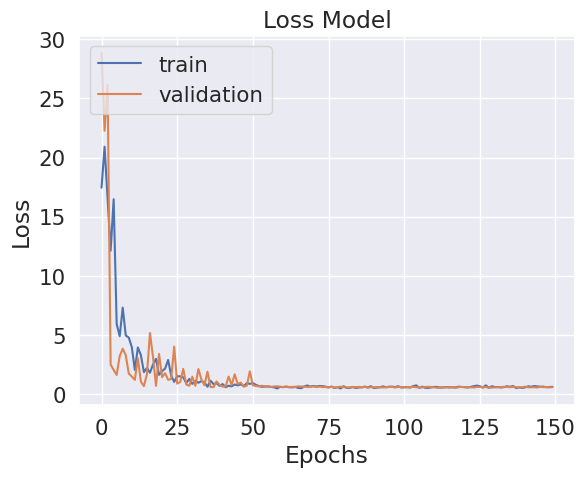

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

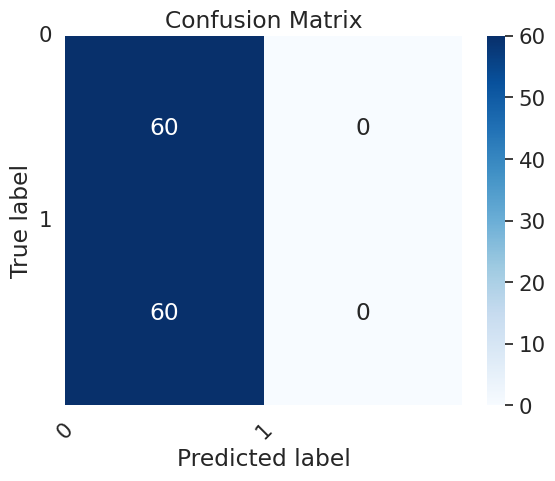

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define the labels
labels = ['0','1']
categories = ['Zero', 'One']

# create the confusion matrix plot
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)

# set the axis labels and the title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# add the labels for each cell
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels, rotation=0)

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# calculate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# print the classification report
print(report)


              precision    recall  f1-score   support

        Zero       0.50      1.00      0.67        60
         One       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
